In [ ]:
!pip install torch==1.9.0 torchvision==0.10.0 torchaudio==0.9.0

     |████████████████████████████████| 831.4 MB 2.4 kB/s 
     |████████████████████████████████| 22.1 MB 1.4 MB/s 
     |████████████████████████████████| 1.9 MB 54.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import torchvision
from torchvision import io
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


## Load the data
* Source of the data: https://github.com/lindawangg/COVID-Net
* I've taken the data from: https://drive.google.com/drive/folders/10PIW4rpVU8AETpNDZpyxPmJo00vOwJE7
* The data were gathered by Dominik Chodounský for his bachelor thesis: https://dspace.cvut.cz/handle/10467/95031

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!jar xvf gdrive/MyDrive/Diploma/COVIDx8B.zip

Výstupní stream byl oříznut na posledních 5000 řádků.
 inflated: COVIDx8B/train/negative/c8f8c1af-28f3-420d-85d6-9501a8002097.png
 inflated: COVIDx8B/train/negative/c907dcd1-6011-430b-9515-009900b4a98f.png
 inflated: COVIDx8B/train/negative/c90a1623-b7a2-443b-a20c-a3915df8dac2.png
 inflated: COVIDx8B/train/negative/c90ba168-4d65-4205-90e5-4f96d693d54a.png
 inflated: COVIDx8B/train/negative/c90cbfe6-d98f-407b-b3c2-45b27fd1ae72.png
 inflated: COVIDx8B/train/negative/c919262d-e632-4d1b-9d92-7a8923258ae3.png
 inflated: COVIDx8B/train/negative/c91c57aa-ced9-4499-a231-36b78e5fa786.png
 inflated: COVIDx8B/train/negative/c91c84ab-e310-43fb-adfb-9d351786b01f.png
 inflated: COVIDx8B/train/negative/c93f9fee-9ad2-43a8-9071-ba769cbbdf8a.png
 inflated: COVIDx8B/train/negative/c9449bea-76b0-42e0-827b-2677f6c2f1c8.png
 inflated: COVIDx8B/train/negative/c9464c74-1f7f-41a2-a6ac-c72e8afcbb00.png
 inflated: COVIDx8B/train/negative/c94652f9-22cd-48d2-bb01-5f54abbb7d72.png
 inflated: COVIDx8B/train/negative

In [ ]:
!rm -rf 'COVIDx8B/train/negative/.ipynb_checkpoints'

In [ ]:
import sys
sys.path.append('gdrive/MyDrive/Diploma')
import image_preprocessing

## Prepare the dataset in the pytorch format

In [ ]:
ROOT_PATH = 'COVIDx8B'
TRAIN_DIR = os.path.join(ROOT_PATH, 'train')
TEST_DIR = os.path.join(ROOT_PATH, 'test')

img_size = (224, 224)

In [ ]:
class Covidx8bDataset(Dataset):
  def __init__(self, img_dir, transform=None):
    self.img_paths = [os.path.join(img_dir, 'negative') + '/' + img_file for img_file in os.listdir(os.path.join(img_dir, 'negative'))] \
                     + [os.path.join(img_dir, 'positive') + '/' + img_file for img_file in os.listdir(os.path.join(img_dir, 'positive'))] 
    self.img_labels = np.concatenate((np.full(shape=(len(os.listdir(os.path.join(img_dir, 'negative'))), ), fill_value=0), 
                                      np.full(shape=(len(os.listdir(os.path.join(img_dir, 'positive'))), ), fill_value=1)))
    self.transform = transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    image = Image.open(img_path).convert('RGB')
    label = self.img_labels[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

## Preprocessing
* resize to 224x224
* convert to pytorch tensor
* use contrast limited adaptive histogram equalization (CLAHE) with 40 clip limits

In [ ]:
class CLAHE(object):
  def __call__(self, img):
    img = 255 * np.array(img.permute(1, 2, 0))
    _, new_img = image_preprocessing.rgb_clahe(img, clip_limit=40)
    back2tensor = transforms.ToTensor()

    return back2tensor(new_img)

In [ ]:
transform = transforms.Compose([
  transforms.Resize((img_size[0], img_size[1])),
  transforms.ToTensor(),
  CLAHE(),
  #transforms.Normalize(train_mean, train_std)                         
])

In [ ]:
#train_data = Covidx8bDataset(TRAIN_DIR, transform=transform)
train_data, val_data = torch.utils.data.random_split(Covidx8bDataset(TRAIN_DIR, transform=transform), [13000, 2952], generator=torch.Generator().manual_seed(1))
test_data = Covidx8bDataset(TEST_DIR, transform=transform)
print(f'train data len = {len(train_data)}')
print(f'val data len = {len(val_data)}')
print(f'test data len = {len(test_data)}')

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

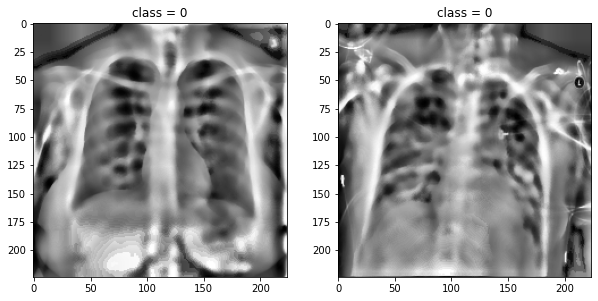

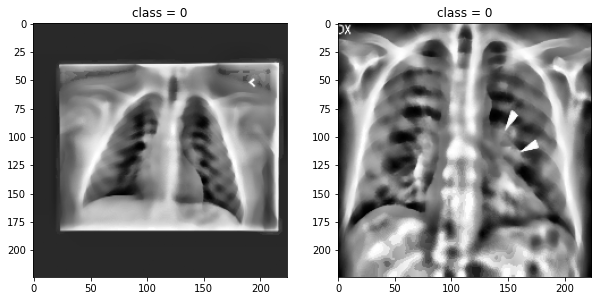

In [ ]:
loader = DataLoader(train_data, batch_size=100, num_workers=1, shuffle=True)
batch = next(iter(loader))

for k in range(2):  
  fig, ax = plt.subplots(1,2,figsize=(10,8))
  for i in range(2):
    j = np.random.randint(64)
    ax[i].imshow(batch[0][j].permute(1, 2, 0))
    ax[i].set_title('class = ' + str(batch[1][j].item()))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
train_class_weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=train_data.dataset.img_labels[train_data.indices]) ,dtype=torch.float).to(device)
print(train_class_weights)

tensor([0.5781, 3.6995], device='cuda:0')


## Model 1) ResNet50 fine-tuning (no class balancing)

In [ ]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(2048, 2)
resnet50.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
epochs = 20
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    for data, labels in train_dataloader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        target = resnet50(data)
        loss = criterion(target, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    for data, labels in val_dataloader:
      data, labels = data.to(device), labels.to(device)  
      target = resnet50(data)
      loss = criterion(target,labels)
      valid_loss = loss.item() * data.size(0)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {valid_loss / len(val_dataloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(resnet50.state_dict(), 'gdrive/MyDrive/Diploma/model_weights/resnet50_save.pth')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 		 Training Loss: 0.12311337917072913 		 Validation Loss: 0.04389859271305863
Validation Loss Decreased(inf--->4.082569) 	 Saving The Model
Epoch 2 		 Training Loss: 0.053899978718855386 		 Validation Loss: 0.10467460591305969
Epoch 3 		 Training Loss: 0.028626043582549637 		 Validation Loss: 0.049913780663603094
Epoch 4 		 Training Loss: 0.027653862405579804 		 Validation Loss: 0.07655053497642599
Epoch 5 		 Training Loss: 0.014501616421541203 		 Validation Loss: 0.01456040592603786
Validation Loss Decreased(4.082569--->1.354118) 	 Saving The Model
Epoch 6 		 Training Loss: 0.017146230824548955 		 Validation Loss: 0.005407557051668885
Validation Loss Decreased(1.354118--->0.502903) 	 Saving The Model
Epoch 7 		 Training Loss: 0.015828611287606938 		 Validation Loss: 0.0004371053749515164
Validation Loss Decreased(0.502903--->0.040651) 	 Saving The Model
Epoch 8 		 Training Loss: 0.01584282651101625 		 Validation Loss: 1.0767593599295103e-05
Validation Loss Decreased(0.040651--

## Model 2) ResNet50 fine-tuning (with class balancing)

In [ ]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(2048, 2)
resnet50.to(device)

criterion = nn.CrossEntropyLoss(weight=train_class_weights)
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()
!nvidia-smi

Sat Dec 25 23:56:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    43W / 250W |   2711MiB / 16280MiB |     54%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
epochs = 20
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    for data, labels in train_dataloader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        target = resnet50(data)
        loss = criterion(target, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    for data, labels in val_dataloader:
      data, labels = data.to(device), labels.to(device)  
      target = resnet50(data)
      loss = criterion(target,labels)
      valid_loss = loss.item() * data.size(0)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {valid_loss / len(val_dataloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        #torch.save(resnet50.state_dict(), 'gdrive/MyDrive/Diploma/model_weights/resnet50_save.pth')

Epoch 1 		 Training Loss: 0.188026476560124 		 Validation Loss: 0.02011703557156502
Validation Loss Decreased(inf--->0.945501) 	 Saving The Model
Epoch 2 		 Training Loss: 0.0674573394673073 		 Validation Loss: 0.08829121894024788
Epoch 3 		 Training Loss: 0.03992870008982672 		 Validation Loss: 0.02713463915155289
Epoch 4 		 Training Loss: 0.02837021245510436 		 Validation Loss: 0.006622083009557521
Validation Loss Decreased(0.945501--->0.311238) 	 Saving The Model
Epoch 5 		 Training Loss: 0.01848681206305913 		 Validation Loss: 0.0013759886013700606
Validation Loss Decreased(0.311238--->0.064671) 	 Saving The Model
Epoch 6 		 Training Loss: 0.02566471134253102 		 Validation Loss: 0.036373146036837965
Epoch 7 		 Training Loss: 0.030673931020240106 		 Validation Loss: 0.04042145546446455
Epoch 8 		 Training Loss: 0.01164699518802295 		 Validation Loss: 4.05338211381372e-05
Validation Loss Decreased(0.064671--->0.001905) 	 Saving The Model
Epoch 9 		 Training Loss: 0.00270501230937168 

In [ ]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(2048, 2)
resnet50.load_state_dict(torch.load('gdrive/MyDrive/Diploma/model_weights/resnet50_weighted_save.pth'))
resnet50.to(device)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = resnet50(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 400 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 400 test images: 74 %


In [ ]:
del dense121

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

import gc
gc.collect()

!nvidia-smi

Tue Dec 28 23:14:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    36W / 250W |   2973MiB / 16280MiB |     22%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 3) DenseNet121 fine-tunin (without weighted samples)
* I've lost the training loop output for this model and just re-running for the sake of it didn't feel neccessary

In [ ]:
dense121 = torchvision.models.densenet121(pretrained=True)
dense121.classifier = nn.Linear(1024, 2)
dense121.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dense121.parameters(), lr=0.001)

print(dense121)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
dense121 = torchvision.models.densenet121(pretrained=True)
dense121.classifier = nn.Linear(1024, 2)
dense121.load_state_dict(torch.load('gdrive/MyDrive/Diploma/model_weights/dense121_save.pth'))
dense121.to(device)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = dense121(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 400 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 400 test images: 78 %


## Model 4) DenseNet121 fine-tuning (with class balancing)

In [ ]:
dense121 = torchvision.models.densenet121(pretrained=True)
dense121.classifier = nn.Linear(1024, 2)
dense121.to(device)

criterion = nn.CrossEntropyLoss(weight=train_class_weights)
optimizer = optim.Adam(dense121.parameters(), lr=0.001)

print(dense121)

In [ ]:
epochs = 20
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    for data, labels in train_dataloader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        target = dense121(data)
        loss = criterion(target, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    for data, labels in val_dataloader:
      data, labels = data.to(device), labels.to(device)  
      target = dense121(data)
      loss = criterion(target,labels)
      valid_loss = loss.item() * data.size(0)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {valid_loss / len(val_dataloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(dense121.state_dict(), 'gdrive/MyDrive/Diploma/model_weights/dense121_weighted_save.pth')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 		 Training Loss: 0.295808276358342 		 Validation Loss: 0.04365055535429267
Validation Loss Decreased(inf--->4.059502) 	 Saving The Model
Epoch 2 		 Training Loss: 0.2097768140201633 		 Validation Loss: 0.010457782335178826
Validation Loss Decreased(4.059502--->0.972574) 	 Saving The Model
Epoch 3 		 Training Loss: 0.16668268458125998 		 Validation Loss: 0.0018333124537621775
Validation Loss Decreased(0.972574--->0.170498) 	 Saving The Model
Epoch 4 		 Training Loss: 0.15469109319855232 		 Validation Loss: 0.06081665715863628
Epoch 5 		 Training Loss: 0.12673789673400196 		 Validation Loss: 0.010639773902072701
Epoch 6 		 Training Loss: 0.1275261487349575 		 Validation Loss: 0.012929457490162184
Epoch 7 		 Training Loss: 0.12077286559058678 		 Validation Loss: 0.054036719824678156
Epoch 8 		 Training Loss: 0.11484249873448356 		 Validation Loss: 0.014430852346522834
Epoch 9 		 Training Loss: 0.10372828217240448 		 Validation Loss: 0.13989505972913516
Epoch 10 		 Training Loss: 

In [ ]:
dense121 = torchvision.models.densenet121(pretrained=True)
dense121.classifier = nn.Linear(1024, 2)
dense121.load_state_dict(torch.load('gdrive/MyDrive/Diploma/model_weights/dense121_weighted_save.pth'))
dense121.to(device)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = dense121(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 400 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 400 test images: 83 %


## Model 5) CheXnet fine-tuning (with class balancing)

In [ ]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.densenet121(x)
        return x

chexnet = DenseNet121(14).cuda()
chexnet = torch.nn.DataParallel(chexnet).cuda()

from collections import OrderedDict
import re

checkpoint = torch.load('gdrive/MyDrive/Diploma/model_weights/chexnet_checkpoint.pth.tar')
state_dict = OrderedDict()

for key in checkpoint['state_dict']:
  new_key = key.replace('.norm.1', '.norm1').replace('.norm.2', '.norm2').replace('.conv.1', '.conv1').replace('.conv.2', '.conv2')
  state_dict[new_key] = checkpoint['state_dict'][key]

chexnet.load_state_dict(state_dict, strict=False)  

chexnet.classifier = nn.Linear(1024, 2)

criterion = nn.CrossEntropyLoss(weight=train_class_weights)
optimizer = optim.Adam(chexnet.parameters(), lr=0.0001)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
epochs = 20
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    for data, labels in train_dataloader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        target = chexnet(data)
        loss = criterion(target, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    for data, labels in val_dataloader:
      data, labels = data.to(device), labels.to(device)  
      target = chexnet(data)
      loss = criterion(target,labels)
      valid_loss = loss.item() * data.size(0)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {valid_loss / len(val_dataloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(chexnet.state_dict(), 'gdrive/MyDrive/Diploma/model_weights/chexnet_weighted_save.pth')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 		 Training Loss: 0.29433672644509146 		 Validation Loss: 0.07700111532724031
Validation Loss Decreased(inf--->7.161104) 	 Saving The Model
Epoch 2 		 Training Loss: 0.11755954425928414 		 Validation Loss: 0.007314562156636228
Validation Loss Decreased(7.161104--->0.680254) 	 Saving The Model
Epoch 3 		 Training Loss: 0.06341031463061636 		 Validation Loss: 0.0004503105276374407
Validation Loss Decreased(0.680254--->0.041879) 	 Saving The Model
Epoch 4 		 Training Loss: 0.04132340255442833 		 Validation Loss: 0.00032691098749637604
Validation Loss Decreased(0.041879--->0.030403) 	 Saving The Model
Epoch 5 		 Training Loss: 0.028832840384556215 		 Validation Loss: 0.0003768953504741833
Epoch 6 		 Training Loss: 0.017106122061903692 		 Validation Loss: 0.023453235626220703
Epoch 7 		 Training Loss: 0.014097207504526555 		 Validation Loss: 0.00024954327732645056
Validation Loss Decreased(0.030403--->0.023208) 	 Saving The Model
Epoch 8 		 Training Loss: 0.01175253108759921 		 Vali

In [ ]:
del chexnet

with torch.no_grad():
    torch.cuda.empty_cache()

import gc
gc.collect()

!nvidia-smi

Wed Dec 29 02:42:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    36W / 250W |   3471MiB / 16280MiB |     75%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.densenet121(x)
        return x

chexnet = DenseNet121(14).cuda()
chexnet = torch.nn.DataParallel(chexnet).cuda()

from collections import OrderedDict
import re

checkpoint = torch.load('gdrive/MyDrive/Diploma/model_weights/chexnet_checkpoint.pth.tar')
state_dict = OrderedDict()

for key in checkpoint['state_dict']:
  new_key = key.replace('.norm.1', '.norm1').replace('.norm.2', '.norm2').replace('.conv.1', '.conv1').replace('.conv.2', '.conv2')
  state_dict[new_key] = checkpoint['state_dict'][key]

chexnet.load_state_dict(state_dict, strict=False)  

chexnet.classifier = nn.Linear(1024, 2)

criterion = nn.CrossEntropyLoss(weight=train_class_weights)
optimizer = optim.Adam(chexnet.parameters(), lr=0.00001)

In [ ]:
epochs = 20
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    for data, labels in train_dataloader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        target = chexnet(data)
        loss = criterion(target, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    for data, labels in val_dataloader:
      data, labels = data.to(device), labels.to(device)  
      target = chexnet(data)
      loss = criterion(target,labels)
      valid_loss = loss.item() * data.size(0)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {valid_loss / len(val_dataloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(chexnet.state_dict(), 'gdrive/MyDrive/Diploma/model_weights/chexnet_weighted_lr0.00001_save.pth')

Epoch 1 		 Training Loss: 0.5766732793035906 		 Validation Loss: 0.046908311946417695
Validation Loss Decreased(inf--->4.362473) 	 Saving The Model
Epoch 2 		 Training Loss: 0.397000703164342 		 Validation Loss: 0.015572462030636367
Validation Loss Decreased(4.362473--->1.448239) 	 Saving The Model
Epoch 3 		 Training Loss: 0.2914342156059912 		 Validation Loss: 0.007227797021148025
Validation Loss Decreased(1.448239--->0.672185) 	 Saving The Model
Epoch 4 		 Training Loss: 0.2313322910823898 		 Validation Loss: 0.04309096900365686
Epoch 5 		 Training Loss: 0.19181849360832126 		 Validation Loss: 0.034537940896967406
Epoch 6 		 Training Loss: 0.16344774297509498 		 Validation Loss: 0.00484953676500628
Validation Loss Decreased(0.672185--->0.451007) 	 Saving The Model
Epoch 7 		 Training Loss: 0.14187108231502463 		 Validation Loss: 0.019155422846476238
Epoch 8 		 Training Loss: 0.12222284067614365 		 Validation Loss: 0.09554324611540764
Epoch 9 		 Training Loss: 0.10266270832884004 		 

## Model 7) CheXnet fine-tuning (without class balancing)

In [ ]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.densenet121(x)
        return x

chexnet = DenseNet121(14).cuda()
chexnet = torch.nn.DataParallel(chexnet).cuda()

from collections import OrderedDict
import re

checkpoint = torch.load('gdrive/MyDrive/Diploma/model_weights/chexnet_checkpoint.pth.tar')
state_dict = OrderedDict()

for key in checkpoint['state_dict']:
  new_key = key.replace('.norm.1', '.norm1').replace('.norm.2', '.norm2').replace('.conv.1', '.conv1').replace('.conv.2', '.conv2')
  state_dict[new_key] = checkpoint['state_dict'][key]

chexnet.load_state_dict(state_dict, strict=False)  

chexnet.classifier = nn.Linear(1024, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(chexnet.parameters(), lr=0.0001)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
epochs = 20
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    for data, labels in train_dataloader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        target = chexnet(data)
        loss = criterion(target, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    for data, labels in val_dataloader:
      data, labels = data.to(device), labels.to(device)  
      target = chexnet(data)
      loss = criterion(target,labels)
      valid_loss = loss.item() * data.size(0)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {valid_loss / len(val_dataloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(chexnet.state_dict(), 'gdrive/MyDrive/Diploma/model_weights/chexnet_save.pth')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 		 Training Loss: 0.18380364021446546 		 Validation Loss: 0.012779399912844422
Validation Loss Decreased(inf--->1.188484) 	 Saving The Model
Epoch 2 		 Training Loss: 0.08119406042556468 		 Validation Loss: 0.014288889464511666
Epoch 3 		 Training Loss: 0.0396306012254849 		 Validation Loss: 0.0012954029665198377
Validation Loss Decreased(1.188484--->0.120472) 	 Saving The Model
Epoch 4 		 Training Loss: 0.02059444422707481 		 Validation Loss: 0.005520132280165149
Epoch 5 		 Training Loss: 0.011543769131961487 		 Validation Loss: 4.6119324222046844e-05
Validation Loss Decreased(0.120472--->0.004289) 	 Saving The Model
Epoch 6 		 Training Loss: 0.008980266225846892 		 Validation Loss: 0.0005541249548876157
Epoch 7 		 Training Loss: 0.009399227631657044 		 Validation Loss: 0.0031560031316613638
Epoch 8 		 Training Loss: 0.007524736968217491 		 Validation Loss: 0.09762294318086358
Epoch 9 		 Training Loss: 0.010393426338582831 		 Validation Loss: 0.0001744260230372029
Epoch 10 		 

In [ ]:
del chexnet

with torch.no_grad():
    torch.cuda.empty_cache()

import gc
gc.collect()

!nvidia-smi

Wed Dec 29 02:42:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    36W / 250W |   3471MiB / 16280MiB |     75%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.densenet121(x)
        return x

chexnet = DenseNet121(14).cuda()
chexnet = torch.nn.DataParallel(chexnet).cuda()

from collections import OrderedDict
import re

checkpoint = torch.load('gdrive/MyDrive/Diploma/model_weights/chexnet_checkpoint.pth.tar')
state_dict = OrderedDict()

for key in checkpoint['state_dict']:
  new_key = key.replace('.norm.1', '.norm1').replace('.norm.2', '.norm2').replace('.conv.1', '.conv1').replace('.conv.2', '.conv2')
  state_dict[new_key] = checkpoint['state_dict'][key]

chexnet.load_state_dict(state_dict, strict=False)  

chexnet.classifier = nn.Linear(1024, 2)

criterion = nn.CrossEntropyLoss(weight=train_class_weights)
optimizer = optim.Adam(chexnet.parameters(), lr=0.00001)

In [ ]:
epochs = 20
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    for data, labels in train_dataloader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        target = chexnet(data)
        loss = criterion(target, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    for data, labels in val_dataloader:
      data, labels = data.to(device), labels.to(device)  
      target = chexnet(data)
      loss = criterion(target,labels)
      valid_loss = loss.item() * data.size(0)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {valid_loss / len(val_dataloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(chexnet.state_dict(), 'gdrive/MyDrive/Diploma/model_weights/chexnet_weighted_lr0.00001_save.pth')

Epoch 1 		 Training Loss: 0.5766732793035906 		 Validation Loss: 0.046908311946417695
Validation Loss Decreased(inf--->4.362473) 	 Saving The Model
Epoch 2 		 Training Loss: 0.397000703164342 		 Validation Loss: 0.015572462030636367
Validation Loss Decreased(4.362473--->1.448239) 	 Saving The Model
Epoch 3 		 Training Loss: 0.2914342156059912 		 Validation Loss: 0.007227797021148025
Validation Loss Decreased(1.448239--->0.672185) 	 Saving The Model
Epoch 4 		 Training Loss: 0.2313322910823898 		 Validation Loss: 0.04309096900365686
Epoch 5 		 Training Loss: 0.19181849360832126 		 Validation Loss: 0.034537940896967406
Epoch 6 		 Training Loss: 0.16344774297509498 		 Validation Loss: 0.00484953676500628
Validation Loss Decreased(0.672185--->0.451007) 	 Saving The Model
Epoch 7 		 Training Loss: 0.14187108231502463 		 Validation Loss: 0.019155422846476238
Epoch 8 		 Training Loss: 0.12222284067614365 		 Validation Loss: 0.09554324611540764
Epoch 9 		 Training Loss: 0.10266270832884004 		 